In [1]:
import texthero as hero
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import ImageColor
import colorsys
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm
# import optuna.integration.lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import nltk
import warnings

pd.set_option('display.max_Columns', 100)
warnings.simplefilter('ignore', UserWarning)

In [2]:
color = pd.read_csv('../input/color.csv')
color_rgb = pd.DataFrame(color['hex'].str.strip().map(ImageColor.getrgb).values.tolist(), 
                         columns=['color_r', 'color_g', 'color_b'])
color = pd.concat([color, color_rgb], axis=1)
color['ratio'] = color['percentage']/100
print('color', color.shape)

color (73636, 7)


In [3]:
palette = pd.read_csv('../input/palette.csv')
print('palette', palette.shape)
material = pd.read_csv('../input/material.csv')
print('material', material.shape)
object_collection = pd.read_csv('../input/object_collection.csv')
print('object_collection', object_collection.shape)
technique = pd.read_csv('../input/technique.csv')
print('technique', technique.shape)
production_place = pd.read_csv('../input/production_place.csv')
print('production_place', production_place.shape)
production_country = pd.read_csv('../input/production_country.csv')
print('production_country', production_country.shape)
historical_person = pd.read_csv('../input/historical_person.csv')
print('historical_person', historical_person.shape)
maker = pd.read_csv('../input/maker.csv')
print('maker', maker.shape)
principal_maker = pd.read_csv('../input/principal_maker.csv')
print('principal_maker', principal_maker.shape)
principal_maker_occupation = pd.read_csv('../input/principal_maker_occupation.csv')
print('principal_maker_occupation', principal_maker_occupation.shape)
train = pd.read_csv('../input/train.csv')
print('train', train.shape)
test = pd.read_csv('../input/test.csv')
print('test', test.shape)
whole = pd.concat([train, test])
print('whole', whole.shape)

palette (527890, 5)
material (35394, 2)
object_collection (14210, 2)
technique (20481, 2)
production_place (17686, 2)
production_country (17686, 2)
historical_person (6745, 2)
maker (3291, 6)
principal_maker (24538, 6)
principal_maker_occupation (25372, 2)
train (12026, 19)
test (12008, 18)
whole (24034, 19)


### Text

In [4]:
def text_normalization(text):

    # 英語とオランダ語を stopword として指定
    custom_stopwords = nltk.corpus.stopwords.words('dutch') + nltk.corpus.stopwords.words('english')

    x = hero.clean(text, pipeline=[
        hero.preprocessing.fillna,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
    ])

    return x

In [5]:
class AbstractBaseBlock:
    def fit(self, input_df: pd.DataFrame, y=None):
        return self.transform(input_df)

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError()

In [6]:
class TfidfBlock(AbstractBaseBlock):
    """tfidf x SVD による圧縮を行なう block"""
    def __init__(self, column: str, n_topic=50):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.n_topic = n_topic

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def fit(self, input_df, y=None):
        text = self.preprocess(input_df)
        self.pileline_ = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=10000)),
            ('svd', TruncatedSVD(n_components=self.n_topic)),
        ])

        self.pileline_.fit(text)
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)

        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'{self.column}_tfidf_')

In [7]:
def create_long_more_title(df_input):
    df_input['long_more_title'] = df_input['long_title'].str.cat(df_input['more_title'], sep=' ')

In [8]:
create_long_more_title(train)
create_long_more_title(test)
create_long_more_title(whole)

In [9]:
%%time
desc_block = TfidfBlock('description')
x = desc_block.fit(train)

title_block = TfidfBlock('title', 30)
x = title_block.fit(train)

longtitle_block = TfidfBlock('long_more_title')
x = longtitle_block.fit(train)

/Users/umeharayasunobu/opt/anaconda3/envs/newest/lib/python3.9/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/Users/umeharayasunobu/opt/anaconda3/envs/newest/lib/python3.9/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


CPU times: user 20.8 s, sys: 912 ms, total: 21.7 s
Wall time: 18.3 s


In [10]:
def create_text_description_feature(df_input):
    return desc_block.transform(df_input)

def create_text_title_feature(df_input):
    return title_block.transform(df_input)

def create_text_longtitle_feature(df_input):
    return longtitle_block.transform(df_input)

#### Color

In [11]:
def rgb_to_h(row):
    return colorsys.rgb_to_hsv(row['R'], row['G'], row['B'])[0]

def rgb_to_s(row):
    return colorsys.rgb_to_hsv(row['R'], row['G'], row['B'])[1]

def rgb_to_v(row):
    return colorsys.rgb_to_hsv(row['R'], row['G'], row['B'])[2]

def get_total_color(color_input):
    cp = color_input.copy()
    cp['R'] = cp['color_r']*cp['ratio']/255
    cp['G'] = cp['color_g']*cp['ratio']/255
    cp['B'] = cp['color_b']*cp['ratio']/255
    rgb = cp.groupby('object_id').sum()[['R','G','B']]
    rgb['H'] = rgb.apply(rgb_to_h, axis=1)
    rgb['S'] = rgb.apply(rgb_to_s, axis=1)
    rgb['V'] = rgb.apply(rgb_to_v, axis=1)
    return rgb

main_color = get_total_color(color).add_prefix('color_').reset_index()
main_palette = get_total_color(palette).add_prefix('plt_').reset_index()

In [12]:
def create_main_color_feature(df_input):
    cp = df_input[['object_id']].copy()
    cp = pd.merge(cp, main_color, on='object_id', how='left')
    cp = pd.merge(cp, main_palette, on='object_id', how='left')
    cp = cp.fillna(0).drop(columns=['object_id'])
    cp.index = df_input.index
    return cp

In [13]:
def get_color_count(df_input, color_input, col):
    color_cp = color_input[color_input['ratio'] > 0.05].copy()
    group = color_cp.groupby('object_id').size().rename(col).reset_index()
    cp = df_input[['object_id']].copy()
    cp = pd.merge(cp, group, on='object_id', how='left').fillna(0)
    return cp[[col]]

def create_color_count_feature(df_input):
    color_count = get_color_count(df_input, color, 'color_count')
    color_count.index = df_input.index
    palette_count = get_color_count(df_input, palette, 'palette_count')
    palette_count.index = df_input.index
    return pd.concat([color_count, palette_count], axis=1)

In [14]:
def get_color_corr(color_input, prefix):
    color_cp = color_input.copy()
    col_list = ['color_r', 'color_g', 'color_b']
#     for col in col_list:
#         color_cp[col] = color_cp[col]*color_cp['ratio']
    group_corr = color_cp.groupby('object_id')[col_list].corr()
    pivot = group_corr.reset_index().pivot_table(index='object_id', columns='level_1', values=col_list, aggfunc='sum')
    pivot.columns = ['_'.join(x) for x in list(pivot.columns)]
    drop_col = [x+'_'+x for x in col_list] + ['color_b_color_r', 'color_g_color_b', 'color_r_color_g']
    pivot = pivot.drop(columns=drop_col)
    pivot['sum'] = pivot.sum(axis=1)
    return pivot.add_prefix(prefix).reset_index()

def create_color_corr_feature(df_input):
    color_corr = get_color_corr(color, 'CL_')
    plt_corr = get_color_corr(palette, 'PL_')
    cp = df_input[['object_id']].copy()
    cp = pd.merge(cp, color_corr, on='object_id', how='left')
    cp = pd.merge(cp, plt_corr, on='object_id', how='left')
    cp = cp.fillna(0).drop(columns=['object_id'])
    cp.index = df_input.index
    return cp

#### numeric

In [15]:
def create_numeric_feature(df_input):
    cp = df_input.copy()
    cp['acquisition_year'] = pd.to_datetime(df_input['acquisition_date']).dt.year
    cp['dating_year_early_late'] = cp['dating_year_late'] - cp['dating_year_early'] + 1
    return cp[['acquisition_year', 'dating_sorting_date', 'dating_period', 'dating_year_early', 'dating_year_late', 'dating_year_early_late']]

#### principal_maker

In [16]:
def create_principal_maker_feature(df_input):
    occu_group = principal_maker_occupation.groupby('id').size().rename('occupation_count')
    occu_group = pd.DataFrame(occu_group).reset_index()
    
    maker_cp = pd.merge(principal_maker, occu_group, on='id', how='left')
    
    group = maker_cp.groupby('object_id').agg({'occupation_count':'sum', 'id':'size'}).reset_index()
    group.rename(columns={'id':'principal_maker_count'}, inplace=True)
    cp = pd.merge(df_input, group, on='object_id', how='left')
    return cp[['occupation_count', 'principal_maker_count']]

In [17]:
def create_maker_feature(df_input):
    maker_cp = maker.copy()
    maker_cp['birth_year'] = 0
    maker_cp.loc[maker_cp['date_of_birth'].notnull(), 'birth_year'] = maker_cp['date_of_birth']
    maker_cp['birth_year'] = maker_cp['birth_year'].apply(lambda x: str(x)[:4]).astype(int)
    
    maker_cp['death_year'] = 0
    maker_cp.loc[maker_cp['date_of_death'].notnull(), 'death_year'] = maker_cp['date_of_death']
    maker_cp['death_year'] = maker_cp['death_year'].apply(lambda x: str(x)[:4]).astype(int)

    maker_cp['maker_death_old'] = maker_cp['death_year'] - maker_cp['birth_year']
    maker_cp.rename(columns={'name': 'principal_maker'}, inplace=True)
    
    cp = pd.merge(df_input, maker_cp, on='principal_maker', how='left')
    return cp[['birth_year', 'death_year', 'maker_death_old']]

#### Count encoding

In [18]:
def create_count_encoding_feature_sub(df_whole, df_input, column):
    cp = df_input.copy()
    newcol = 'CE_'+column
    group = df_whole.groupby(column).size().rename(newcol)
    group = pd.DataFrame(group).reset_index()
    cp = pd.merge(cp, group, on=column, how='left')
    cp = cp[[newcol]].fillna(0)
    cp.index = df_input.index
    return cp

def create_count_encoding_feature(df_input):
    col_list = ['art_series_id', 'principal_maker', 'principal_or_first_maker', 'copyright_holder', 'acquisition_method', 
                'dating_sorting_date', 'dating_period']
    cp = df_input.copy()
    len_cp = len(cp)
    org_col = cp.columns
    for col in col_list:
        tmp = create_count_encoding_feature_sub(whole, cp, col)
        cp = pd.concat([cp, tmp], axis=1)
        assert len(cp) == len_cp
    return cp.drop(columns=org_col)

#### Label encoding

In [19]:
def create_label_encoding_feature(df_input):
    col_list = ['art_series_id', 'principal_maker', 'principal_or_first_maker', 'copyright_holder', 'acquisition_method']
    out_df = pd.DataFrame(index=df_input.index)
    le = LabelEncoder()
    for col in col_list:
        le.fit(whole[col])
        out_df[col] = le.transform(df_input[col])
    return out_df.add_prefix('LE_')

#### One-hot encoding

In [20]:
def get_one_hot_encoding(df_input, df_merge, count, prefix):
    value_counts = df_merge['name'].value_counts()
    col_list = list(value_counts.index[0:count])
    dummy = pd.get_dummies(df_merge['name'])[col_list]
    dummy = pd.concat([df_merge, dummy], axis=1)
    group = dummy.groupby('object_id').sum()
    group = group.add_prefix(prefix).reset_index()
    out = pd.merge(df_input[['object_id']], group, on='object_id', how='left')
    out = out.fillna(0).drop(columns=['object_id'])
    out.index = df_input.index
    return out

def creat_material_feature(df_input):
    return get_one_hot_encoding(df_input, material, 10, 'MT_')

def creat_object_collection_feature(df_input):
    return get_one_hot_encoding(df_input, object_collection, 3, 'OC_')

def creat_production_place_feature(df_input):
    return get_one_hot_encoding(df_input, production_place, 10, 'PP_')

def creat_production_country_feature(df_input):
    return get_one_hot_encoding(df_input, production_country, 17, 'PC_')

def creat_technique_feature(df_input):
    return get_one_hot_encoding(df_input, technique, 10, 'TC_')

def creat_historical_person_feature(df_input):
    ohe = get_one_hot_encoding(df_input, historical_person, 3, 'HP_')
    ohe.columns = ['HP_' + str(i) for i in range(len(ohe.columns))]
    return ohe

#### String length

In [21]:
def create_string_length_feature(df_input):
    out_df = pd.DataFrame()
    str_columns = ['title', 'long_title', 'sub_title', 'more_title', 'description']
    for c in str_columns:
        out_df[c] = df_input[c].str.len()
    return out_df.add_prefix('LN_')

In [22]:
def create_sub_title_feature(df_input):
    out = pd.DataFrame(index=df_input.index)
    out['dimension'] = 0
    for axis in ['h', 'w', 't', 'd']:
        column_name = f'size_{axis}'
        size_info = df_input['sub_title'].str.extract(r'{} (\d*|\d*\.\d*)(cm|mm)'.format(axis))
        size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
        size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float)
        size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) 
        out[column_name] = size_info[column_name]
        out['dimension'] += out[column_name].apply(lambda x: 0 if np.isnan(x) else 1)
    out['area'] = out['size_h'] * out['size_w']
    return out

#### Target encoding

In [23]:
def target_encoding(df_input, target_col, k_fold=5):
    encoding_col = 'TE_' + target_col
    X = df_input
    out = pd.DataFrame(index=X.index)
    out[encoding_col] = np.NaN

    if 'likes' in df_input.columns:
        # train
        cv = KFold(n_splits=k_fold, shuffle=True, random_state=0)
        for train_index, valid_index in cv.split(X):
            x_train, x_valid = X.iloc[train_index], X.iloc[valid_index]
            likes = x_train.groupby(target_col)[['likes']].mean().reset_index()
            tmp = pd.merge(x_valid[[target_col]], likes, on=[target_col], how='left')
            tmp.index = valid_index
            out.loc[valid_index, encoding_col] = tmp['likes'].apply(np.log1p)
    else:
        # test
        likes = train.groupby(target_col)[['likes']].mean().reset_index()
        tmp = pd.merge(X[[target_col]], likes, on=[target_col], how='left')
        out[encoding_col] = tmp['likes'].apply(np.log1p)
    return out

def creat_target_encoding_principal_maker(df_input):
    return target_encoding(df_input, 'principal_maker')

def creat_target_encoding_principal_or_first_maker(df_input):
    return target_encoding(df_input, 'principal_or_first_maker')

#### All feature

In [24]:
func_list = [
    create_color_corr_feature,
    create_text_description_feature,
    create_text_title_feature,
    create_text_longtitle_feature,
    create_numeric_feature,
    create_count_encoding_feature,
    create_label_encoding_feature,
    create_string_length_feature,
    create_sub_title_feature,
    creat_material_feature,
    creat_object_collection_feature,
    creat_production_place_feature,
    creat_production_country_feature,
    creat_technique_feature,
    creat_historical_person_feature,
    create_main_color_feature,
    create_color_count_feature,
    create_principal_maker_feature,
    create_maker_feature,
]

func_list_w_te = func_list + [
    creat_target_encoding_principal_maker,
    creat_target_encoding_principal_or_first_maker,
]

In [25]:
def create_all_feature(df_input, func_list):
    out = pd.DataFrame(index=df_input.index)
    for func in func_list:
        out = pd.concat([out, func(df_input)], axis=1)
        assert len(df_input) == len(out)
    return out

In [26]:
def split_train_target(df_input):
    target = df_input[['likes']].copy()
    target['target'] = target['likes'].apply(np.log1p)
    return target['target']

In [27]:
LGBM_PARAMS = [
    {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 124, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20},
    {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 1.784047886757114e-08, 'lambda_l2': 5.161650291157943e-06, 'num_leaves': 29, 'feature_fraction': 0.584, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20},
    {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0007745018833180502, 'lambda_l2': 1.9190555245864202e-07, 'num_leaves': 25, 'feature_fraction': 0.8, 'bagging_fraction': 0.9996642823779416, 'bagging_freq': 1, 'min_child_samples': 25},
    {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 0.00011339580973156189, 'lambda_l2': 0.0001687974601137855, 'num_leaves': 31, 'feature_fraction': 0.7200000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20},
    {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 1.2808267029168457e-08, 'lambda_l2': 0.00033073283430080425, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20},
]
KFOLD = 5

In [28]:
# for tuning
# LGBM_PARAMS = [
#     {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1,},
#     {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1,},
#     {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1,},
#     {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1,},
#     {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'verbosity': -1,},
# ]

In [29]:
cat_feat = [
    'LE_art_series_id', 
    'LE_copyright_holder', 'LE_acquisition_method'
]

cat_feat_te = [
    'LE_principal_maker', 'LE_principal_or_first_maker', 
]

cat_feat_w_te = cat_feat + cat_feat_te

In [30]:
def get_stratified(y):
    y_bin = y.astype(int)
    y_bin[y_bin >=8] = 8
    return y_bin

In [31]:
#get_stratified(train_y1).value_counts()

In [32]:
def train_kfold(X, y, cat_feat, k_fold=KFOLD):
    rmse_list = []
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    cv = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=0)
    cv_split = cv.split(X, get_stratified(y))
    
#     cv = KFold(n_splits=k_fold, shuffle=True, random_state=0)
#     cv_split = cv.split(X)

    for i, (train_index, valid_index) in enumerate(cv_split):

        x_train, x_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        params = LGBM_PARAMS[i]

        lgbm_train = lgbm.Dataset(x_train, y_train)
        lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
        lgbm_model = lgbm.train(params, 
                                                lgbm_train, 
                                                valid_sets=lgbm_eval,
                                                num_boost_round=10000,
                                                early_stopping_rounds=100,
                                                categorical_feature = cat_feat,
                                                verbose_eval=-1)
        y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)
        oof_pred[valid_index] = y_pred

        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

        rmse_list.append(rmse)
        models.append(lgbm_model)

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('- TRAIN RMSE={:.4f}'.format(score))

    return models, oof_pred, score

In [33]:
def predict_test(test_X, models):
    pred_list = []
    for model in models:
        pred = model.predict(test_X, num_iteration = model.best_iteration)
        pred_list.append(pred)
    pred_test = np.mean(pred_list, axis=0)
    return pred_test

In [34]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

In [35]:
train_X1 = create_all_feature(train, func_list_w_te)
test_X1 = create_all_feature(test, func_list_w_te)
train_y1 = split_train_target(train)
print(train_X1.shape)
print(train_y1.shape)
print(test_X1.shape)
feat_cnt1 = len(train_X1.columns)

/Users/umeharayasunobu/opt/anaconda3/envs/newest/lib/python3.9/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/Users/umeharayasunobu/opt/anaconda3/envs/newest/lib/python3.9/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
/Users/umeharayasunobu/opt/anaconda3/envs/newest/lib/python3.9/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/Users/umeharayasunobu/opt/anaconda3/envs/newest/lib/python3.9/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{strin

(12026, 241)
(12026,)
(12008, 241)


In [36]:
models1, oof_pred1, score1 = train_kfold(train_X1, train_y1, cat_feat_w_te)
pred1 = predict_test(test_X1, models1)
test_pred1 = revert_to_real(pred1)
print('test_pred1', len(test_pred1))
test_X1['likes'] = test_pred1

<ipython-input-32-a3aeb6a46d94>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  oof_pred = np.zeros_like(y, dtype=np.float)


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[132]	valid_0's rmse: 1.01787
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[298]	valid_0's rmse: 1.03786
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[264]	valid_0's rmse: 1.01675
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	valid_0's rmse: 0.990261
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[222]	valid_0's rmse: 0.975024
- TRAIN RMSE=1.0078
test_pred1 12008


In [37]:
# tuning用
# for model in models1:
#     print(model.params)

In [38]:
test_X = test_X1
assert len(test_X) == len(test)
df_test_pred = test_X[['likes']]

In [39]:
# df_test_pred = pd.DataFrame(test_pred, columns=['likes'])
assert len(df_test_pred) == len(test)
df_test_pred.to_csv('../output/submit.csv', index=False)
df_test_pred.head()

,likes
0,0.917905
1,18.905576
2,0.613426
3,4.343709
4,0.364334


In [40]:
def plot_scatter(target, oof):
    x1 = target
    y1 = oof
    xmax = max(max(x1), max(y1))*1.05
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(x1, y1, alpha=0.3, marker='.')
    ax.plot([0, xmax], [0, xmax], color='black', linewidth=0.5)
    plt.xlabel('Target')
    plt.ylabel('Out of fold')
    plt.xlim(0, xmax)
    plt.ylim(0, xmax)

corr1 = 0.8231694655894639


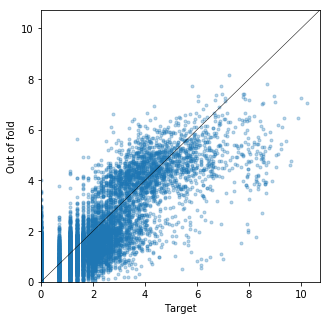

In [41]:
corr1 = train_y1.corr(pd.Series(oof_pred1))
print('corr1 =', corr1)
plot_scatter(train_y1, oof_pred1)

In [42]:
def plot_hist(oof, pred):
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.histplot(pred, label='Test Predict', ax=ax, color='black')
    sns.histplot(oof, label='Out of fold', ax=ax, color='C1')
    ax.legend()
    ax.grid()

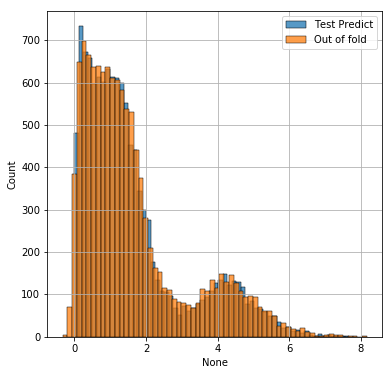

In [43]:
plot_hist(oof_pred1, np.log1p(df_test_pred))

In [44]:
print(f'- feat_cnt = {feat_cnt1}')
print(f'- score = {score1:.5f}')
print(f'- corr = {corr1:.5f}')

- feat_cnt = 241
- score = 1.00780
- corr = 0.82317


#### baseline_17: 色の分散
- feat_cnt = 241
- score = 1.00780
- corr = 0.82317
- LB = 0.9639 ★best★

#### baseline_16: tuning (baseline14)
- feat_cnt = 233
- score = 1.00967
- corr = 0.82242
- LB = 0.9641

#### baseline_15: fit->whole, long_more_titleのみ, titleなし
- feat_cnt = 203
- score = 1.01014
- corr = 0.82217
- LB = 0.968

#### baseline_14: long_more_title(50), title(30)
- feat_cnt = 233
- score = 1.00905
- corr = 0.82265
- LB = 0.9644 ☆best☆

#### baseline_13: title
- feat_cnt = 203
- score = 1.01047
- corr = 0.82207
- LB = 0.9657

#### baseline_12: description
- feat_cnt = 153
- score = 1.01823
- corr = 0.81906
- LB = 0.9804

#### baseline_11: principal_maker, maker
- feat_cnt = 103
- score = 1.03405
- corr = 0.81277
- LB = 1.0012

#### baseline_10-1: tuning
- feat_cnt = 96
- score = 1.03211
- corr = 0.81355
- LB = 1.0026

#### tuning_10:
- feat_cnt = 96
- score = 1.02586
- corr = 0.81605

#### baseline_9-1: TE n_split=5に戻す, testにしかいないprincipal_makerは別モデル
- feat_cnt = 96, 92
- score = 1.03494, 1.05633
- corr = 0.81246, 0.80358
- LB = 1.0732

#### baseline_8: TE n_split=100
- feat_cnt = 96
- score = 1.00019
- corr = 0.82619
- LB = 1.0166

#### baseline_7: TE_principal_maker, TE_principal_or_first_maker
- feat_cnt = 96
- score = 1.03494
- corr = 0.81246
- LB = 1.0083

#### baseline_6: StratifiedKFold(n_splits=5)
- feat_cnt = 94
- score = 1.04358
- corr = 0.80887
- LB = 1.0219

#### baseline_5: dimension, area, country
- feat_cnt = 94
- score = 1.04760
- corr = 0.80725
- LB = 1.0197

#### baseline_4: color_count, categorical_feature
- feat_cnt = 75
- score = 1.05437
- corr = 0.80446
- LB = 1.0223

#### baseline_3: main_color
- feat_cnt = 73
- score = 1.06423
- corr = 0.80027
- LB = 1.0363

#### baseline_2: material, object_collection, place, technique, person
- feat_cnt = 61
- score = 1.07486
- corr = 0.79573
- LB = 1.0525

#### baseline_1: size, string_length
- feat_cnt = 25
- score = 1.11432
- corr = 0.77827
- LB = 1.1037

#### baseline_0
- feat_cnt = 16
- score = 1.20651
- corr = 0.73332
- LB = 1.1827

In [45]:
def visualize_importance(models):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance()
        _df['column'] = model.feature_name()
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

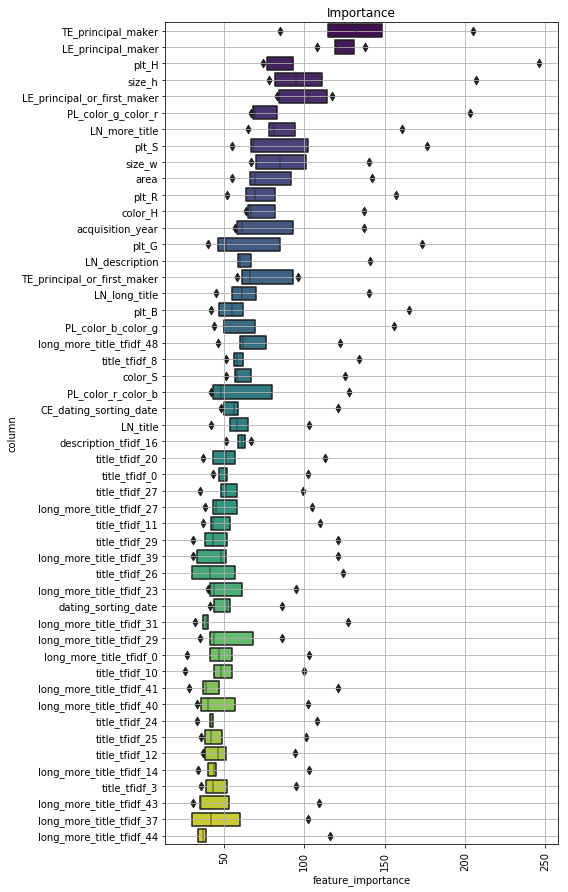

In [46]:
fig, ax = visualize_importance(models1)